In [1]:
import glob, os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import gpflow
from SALib.sample import fast_sampler
from SALib.analyze import fast

2024-03-25 16:12:11.740473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 16:12:11.981538: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 16:12:11.988249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/casper/23.10/spack/opt/spack/openmpi/4.1.6/oneapi/2023.2.1/dgcv/lib:/glade/u/apps/

In [ ]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

### Load data

In [2]:
#read in preprocessed dataset (Leaf Area Index)
ds = xr.open_dataset('./processed_data/metrics/TLAI.nc')

In [3]:
# variable to emulate: global mean annual mean leaf area index averaged over 2005-2014
LAI = ds.TLAI_global_avg_2010

In [4]:
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)

### Train emulator

In [5]:
# Define kernels
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=[1.]*num_params)
kernel_bias = gpflow.kernels.Bias(active_dims = range(num_params))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))
kernel_poly = gpflow.kernels.Polynomial(active_dims = range(num_params),variance=[1.]*num_params)

# set the kernal to use
kernel = kernel_linear + kernel_bias + kernel_RBF + kernel_poly 

2024-03-25 16:12:36.035372: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-25 16:12:36.035419: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc42): /proc/driver/nvidia/version does not exist
2024-03-25 16:12:36.038981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Train emulator

# define data
X = lhc_params.values
y = LAI[1:] # drop the default simulation (index=0)

# Train test split (use first 50 esemble members for validation)
X_train, X_test = X[50:,:], X[:50,:]
y_train, y_test = y[50:].values.reshape(-1,1), y[:50].values.reshape(-1,1)

# define the GPR model 
model = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel, mean_function=None)
#set the optimization althorithm (using Lbfgs)
opt = gpflow.optimizers.Scipy() # select the optimization algorithm (using: lBFGS)
# train the GPR model
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=500))

# save model with tensorflow
#model.predict = tf.function(model.predict_y, input_signature=[tf.TensorSpec(shape=[None, num_params], dtype=tf.float64)])
#savedir = str('./LAI_emulators/')
#tf.saved_model.save(model, savedir)


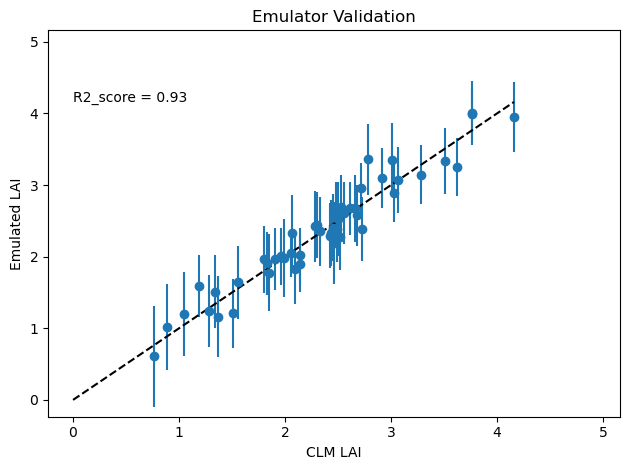

In [17]:
# plot validation
y_pred, y_pred_var = model.predict_y(X_test)
sd = y_pred_var.numpy().flatten()**0.5
    
coef_deter = r2_score(y_test.flatten(),y_pred.numpy())
    
plt.errorbar(y_test.flatten(), y_pred.numpy().flatten(), yerr=3*sd, fmt="o")
plt.text(0,np.max(y_test.flatten()),'R2_score = '+str(np.round(coef_deter,2)),fontsize=10)
plt.plot([0,np.max(y_test.flatten())],[0,np.max(y_test.flatten())],linestyle='--',c='k')
plt.xlabel('CLM LAI')
plt.ylabel('Emulated LAI')
plt.xlim([np.min(y_test.flatten())-1,np.max(y_test.flatten())+1])
plt.ylim([np.min(y_test.flatten())-1,np.max(y_test.flatten())+1])
plt.title('Emulator Validation')
    
plt.tight_layout()
#plt.savefig('./figs/LAIemulator_validation_pft'+str(p)+'.png')

### Perform one at a time sensitivity test using emulator

In [19]:
# One-at-a-time sensitivity 
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = lhc_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

In [22]:
emulator = model

In [30]:
oaat.numpy().flatten()

array([2.45914822, 2.51696302, 2.57173404, 2.62338142, 2.67183825,
       2.71705084, 2.75897887, 2.79759546, 2.83288721, 2.86485404,
       2.89350904, 2.91887824, 2.94100022, 2.95992571, 2.97571715,
       2.98844807, 2.99820254, 3.00507448, 3.00916693, 3.01059135,
       3.00946677])

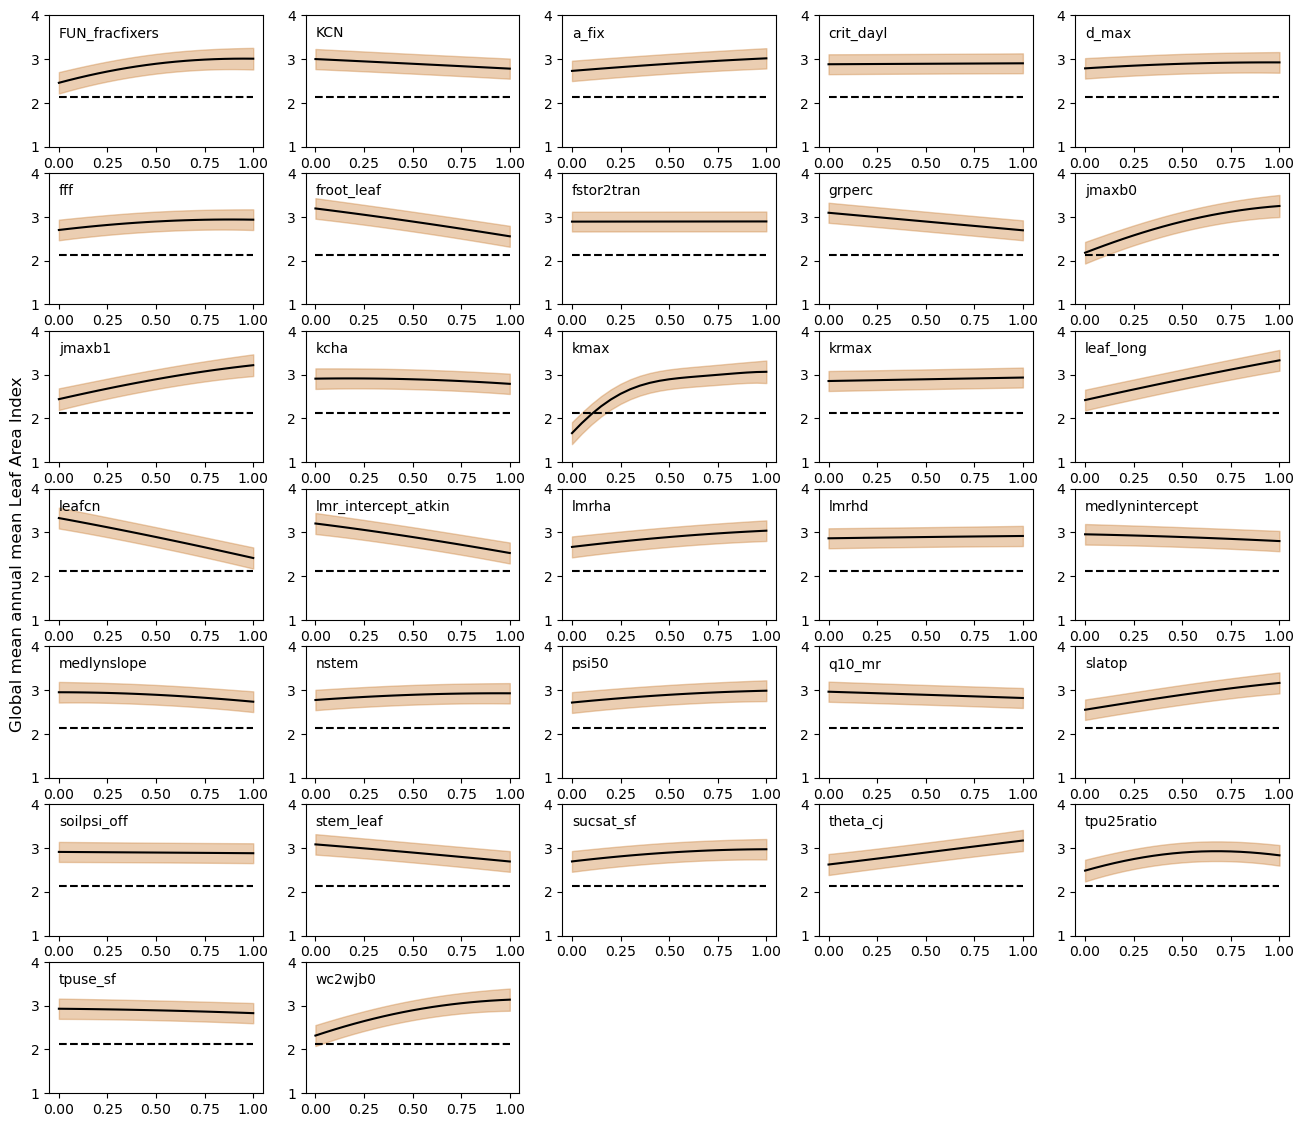

In [31]:
plt.figure(figsize=[16,14])
sample = unif
default = LAI[0]
for i, p in enumerate(lhc_params.columns):
    
    sample[p] = s
    y_pred, y_var = emulator.predict_y(sample.values)
    oaat = y_pred.numpy().flatten()
    stdev = y_var.numpy().flatten()**0.5
    
    sample[p] = np.tile(0.5,n) # set column back to median
    
    ax=plt.subplot(7,5,i+1)
    ax.fill_between(s, oaat-3.0*stdev, oaat+3.0*stdev,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='k')
    
    
    plt.text(0,3.5,p)
    plt.plot([0,1],[default, default],'--',c='k')
    ax.set_ylim([1,4])
    if i == 15:
        plt.ylabel('Global mean annual mean Leaf Area Index',fontsize=12)
    
#plt.savefig('../figs/param_sens/OAAT_sensitivity_GM-AM_GPP.png',dpi=200)

### Fourier amplitude sensitivity test

In [41]:
np.shape(Y)

TensorShape([32000, 1])

In [42]:
# fourier amplitude sensitivity test w/emulator
problem = {
    'names': lhc_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
Y, _ = emulator.predict_f(sample)
FAST = fast.analyze(problem, Y.numpy().flatten(), M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)


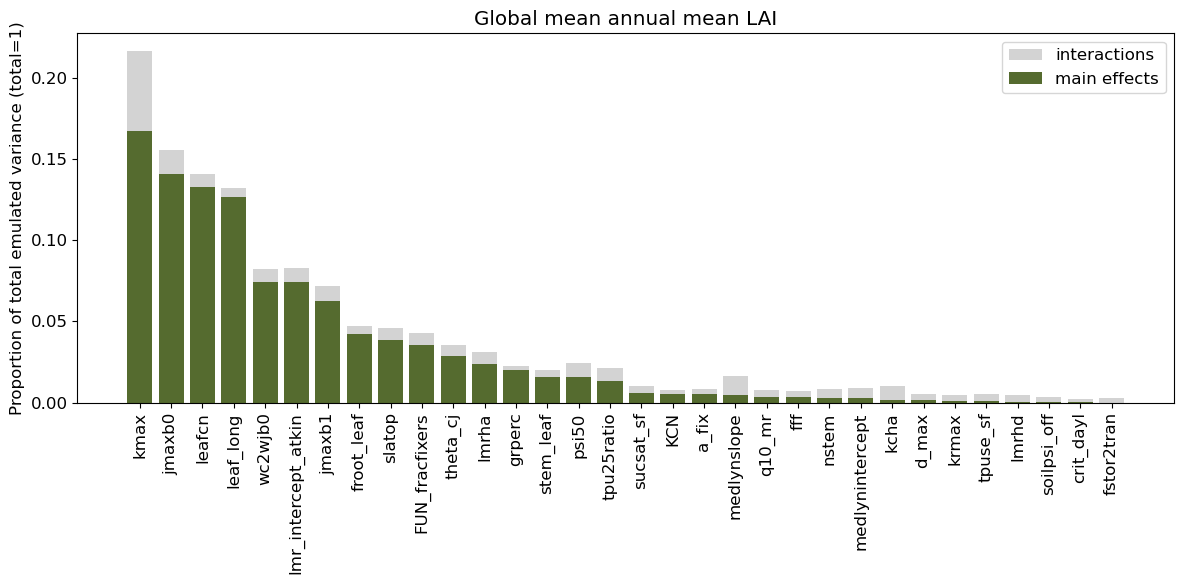

In [50]:
Si = pd.DataFrame.from_dict(FAST)
Si.index = Si.names
df_Si = Si.sort_values(by=['S1'],ascending=False)

plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_Si.names,df_Si['ST'],color='lightgrey',label='interactions')
ax.bar(df_Si.names,df_Si['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Proportion of total emulated variance (total=1)')
plt.title('Global mean annual mean LAI')
plt.tight_layout()

### Sobol sensitivity test

In [45]:
from SALib.sample import saltelli
from SALib.analyze import sobol

In [46]:
# fourier amplitude sensitivity test w/emulator
problem = {
    'names': lhc_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = saltelli.sample(problem, 1024)
Y, _ = emulator.predict_f(sample)
Sobol = sobol.analyze(problem, Y.numpy().flatten())


In [76]:
df_Sobol = pd.DataFrame({'S1':Sobol['S1'],'ST':Sobol['ST']},index = lhc_params.columns)
df_Sobol = df_Sobol.sort_values(by=['ST'],ascending=False)


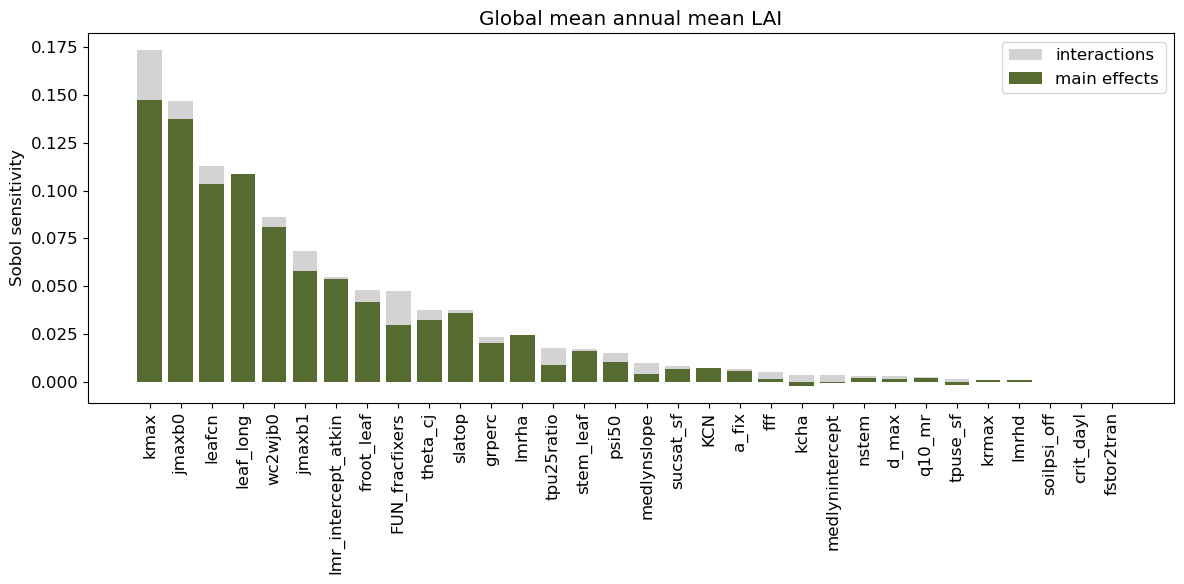

In [79]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_Sobol.index,df_Sobol['ST'],color='lightgrey',label='interactions')
ax.bar(df_Sobol.index,df_Sobol['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Sobol sensitivity')
plt.title('Global mean annual mean LAI')
plt.tight_layout()